## Import lib

In [1]:
from DataSet import DataSet
from SimGPBO import SimGPBO
from PostProcessor import PostProcessor
import GPy
import numpy as np 
import matplotlib.pyplot as plt

c:\Users\deleu\miniconda3\envs\mtl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import data

In [2]:
ds = DataSet('data/','nhp','Cebus1_M1_190221.mat','first_GPBO_validResponses')
ds.load_matlab_data() # load data from the dataset_file

## Find hyperparameters 

In [3]:
pp1 = PostProcessor('results/gpbo_NEI_first_GPBO_validResponses_300it.npz')
pp1.load_data()

In [4]:
print(pp1.P_test_x.shape)
train_X = pp1.P_test_x[:,0]
print(train_X.shape)

(6, 10, 2, 300)
(6, 2, 300)


In [5]:
print(pp1.P_test_y.shape)
train_Y = pp1.P_test_y[:,0]
print(train_Y.shape)

(6, 10, 1, 300)
(6, 1, 300)


In [6]:
kernel = GPy.kern.Matern52(input_dim=2,variance=1.0, lengthscale=[1.0, 1.0], ARD=True, name='Mat52') 

In [7]:
def optimize_gp_hyperparameters(kernel, train_X, train_Y, noise_min=1e-3, noise_max=5.0, max_iters=100):
    """
    Optimise les hyperparamètres d'un modèle GP : longueur d'échelle, variance du noyau, variance du bruit.
    
    Args:
        kernel (GPy.kern.Kern): Le noyau utilisé pour le GP (ex: RBF, Matérn, etc.).
        train_X (np.ndarray): Les données d'entrée pour l'entraînement (n_samples, n_features).
        train_Y (np.ndarray): Les données de sortie correspondantes (n_samples, 1).
        noise_min (float): Borne inférieure pour la variance du bruit.
        noise_max (float): Borne supérieure pour la variance du bruit.
        max_iters (int): Nombre maximum d'itérations pour l'optimisation.
    
    Returns:
        dict: Un dictionnaire contenant les hyperparamètres optimaux :
              - 'lengthscales': Longueurs d'échelle du noyau
              - 'variance': Variance du noyau
              - 'noise_variance': Variance du bruit
    """
    # Créer un modèle GPRegression
    model = GPy.models.GPRegression(train_X, train_Y, kernel=kernel, normalizer=None)
    
    # Contraindre la variance du bruit dans une plage raisonnable
    model.Gaussian_noise.constrain_bounded(noise_min, noise_max, warning=False)
    
    # Optimisation des hyperparamètres
    model.optimize(optimizer='scg', max_iters=max_iters, messages=False)
    
    # Récupération des hyperparamètres optimaux
    lengthscales = model.kern.lengthscale.values if hasattr(model.kern, 'lengthscale') else None
    variance = model.kern.variance.values if hasattr(model.kern, 'variance') else None
    noise_variance = model.Gaussian_noise.variance.values
    
    return {
        "lengthscales": lengthscales,
        "variance": variance,
        "noise_variance": noise_variance
    }

In [8]:
it = np.arange(100, 500+1, 100)
lengthscales_exp = np.zeros((len(it),6,2))
variance_exp = np.zeros((len(it),6))
noise_variance_exp = np.zeros((len(it),6))

for emg in range(6):
    for i in range(len(it)):
        dic=optimize_gp_hyperparameters(kernel=kernel, train_X=train_X[emg, :, :it[i]].T, train_Y=train_Y[emg, :, :it[i]].T, noise_min=1.e-5, noise_max=5, max_iters=100)
        lengthscales_exp[i,emg,:] = dic["lengthscales"]
        variance_exp[i,emg] = dic["variance"]
        noise_variance_exp[i,emg] = dic["noise_variance"]

In [9]:
lengthscale_1_exp = lengthscales_exp[:,:,0]
lengthscale_2_exp = lengthscales_exp[:,:,1]
lengthscale_1_exp_m = np.mean(lengthscale_1_exp, axis=1)
lengthscale_2_exp_m = np.mean(lengthscale_2_exp, axis=1)
variance_exp_m = np.mean(variance_exp, axis=1)
noise_variance_exp_m = np.mean(noise_variance_exp, axis=1)

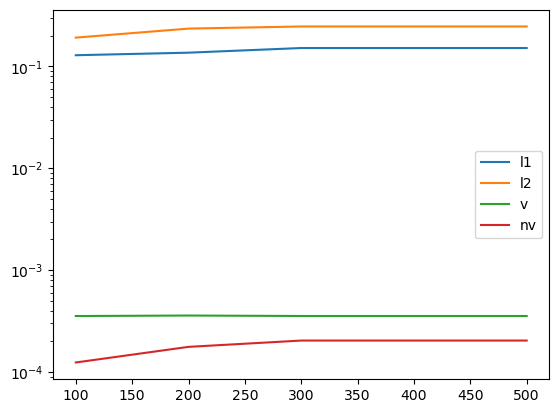

lengthscales:  [0.1516837194453705, 0.2468538010996296] 
variance:  0.0003547026290338991 
noise_variance:  0.00020355777116804128


In [10]:
plt.plot(it,lengthscale_1_exp_m, label='l1')
plt.plot(it,lengthscale_2_exp_m, label='l2')
plt.plot(it,variance_exp_m, label='v')
plt.plot(it,noise_variance_exp_m, label='nv')
plt.legend()
plt.yscale('log')
plt.show()

hyp = {
        "lengthscales": [lengthscale_1_exp_m[-1], lengthscale_2_exp_m[-1]],
        "variance": variance_exp_m[-1],
        "noise_variance": noise_variance_exp_m[-1]
}

print(
        "lengthscales: ", [lengthscale_1_exp_m[-1], lengthscale_2_exp_m[-1]],
        "\nvariance: ", variance_exp_m[-1],
        "\nnoise_variance: ", noise_variance_exp_m[-1]
)

## Simulation 

In [19]:
sim_gpbo = SimGPBO(name = 'hyp_exp', 
                    ds = ds,
                    AF = 'UCB',
                    NB_REP = 2,
                    NB_IT = 1000,
                    KAPPA = 4
                    )

In [20]:
sim_gpbo.select_emgs([0,1])

In [21]:
sim_gpbo.set_custom_gp_hyperparameters(kernel_type='Mat52', noise_std=hyp["noise_variance"], output_std=hyp["variance"], lengthscale=hyp["lengthscales"])

In [22]:
sim_gpbo.run_simulations(gp_origin = 'custom_FixedOnlineGP', mean_and_std_storage = True)

Global Progress: 100%|██████████| 4/4 [00:33<00:00,  8.26s/iter]

Elapsed time: 33.054970502853394 seconds
final save of hyp_exp in:   results/gpbo_custom_FixedOnlineGP_UCB_first_GPBO_validResponses_hyp_exp
